Parte 2
===

In [1]:
import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from sklearn.impute import KNNImputer

## Procedimientos de limpieza y estandarización

In [2]:
columns_to_remove = [
    'nombre_estado', 'numero_pagos_vencidos', 'sistema_operativo', 'Desinstalaciones', 'Activo_saldo_actual', 'Activo_saldo_vencido', 
    '%_Activo', 'Activos_pagos_vencidos', 'Activos_garantia', 'Autos_saldo_actual', 'Autos_saldo_vencido', '%_Autos', 'Autos_pagos_vencidos', 
    'Autos_garantia', 'Comunicaciones_pagos_vencidos', 'consumo_pagos_vencidos', 'Educacion_saldo_actual', 'Educacion_saldo_vencido', 
    '%_educuacion', 'Educacion_pagos_vencidos', 'Educacion_garantia', 'Libranza_saldo_actual', 'Libranza_saldo_vencido', '%_libranza', 
    'Libranza_pagos_vencidos', 'Libranza_garantia', 'Microcredito_saldo_actual', 'Microcredito_saldo_vencido', '%_microcredito', 
    'microcredito_pagos_vencidos', 'microcredito_garantia', 'Otros_saldo_actual', 'Otros_saldo_vencido', '%_otro', 'Otros_pagos_vencidos', 
    'Otros_garantia', 'Tarjeta_credito_saldo_actual', 'Tarjeta_credito_saldo_vencido', '%_tarjeta', 'Tarjeta_pagos_vencidos', 'Tarjeta_garantia', 
    'Vivienda_saldo_actual', 'Vivienda_saldo_vencido', '%_vivienda', 'Vivienda_pagos_vencidos', 'Vivienda_garantia'
] + [
    'Pais', 'Tiene_creditos', 'Tiene_seguros', 'Seguros', 'perfil_usuario', 'monto_bloqueado', 
    'saldo_vencido', 'Comunicaciones_saldo_vencido', 'Consumo_saldo_vencido', 'gestion_de_gastos_impacto',
]

columns_with_negatives = [
    'saldo_actual', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 
    'Comunicaciones_saldo_actual', '%_comunicaciones', 'Consumo_saldo_actual', '%_consumo', 
]

columns_to_fill_with_zero = [
    'saldo_actual', 'Promedio de credito_maximo', 'Promedio de valor_cuota',
    'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 
    'Tiene_ahorro', 'monto_ahorro', 'monto_total',
    'Comunicaciones_saldo_actual', '%_comunicaciones', 'Comunicaciones_garantia', 
    'Consumo_saldo_actual', '%_consumo', 'consumo_garantia',
]

In [6]:
# Procedimientos de limpieza, estandarización y construcción de características

def build_age_ranges(value, ranges):
    range_ = None
    for r in ranges:
        if value in r:
            range_ = r
            break
    return range_


def build_user_profile(value):
    if value == 1:
        return 'Usuario en quiebra'
    elif value == 7:
        return 'Joven'
    elif value >= 150 and value < 400:
        return 'Bajo'
    elif value >= 400 and value < 700:
        return 'Medio'
    elif value >= 700:
        return 'Alto'
    else:
        return 'Sin registro'
    
    
def run_knn_imputer(data, columns):
    data_knn = data.copy()[columns]
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    data_knn_imputer = pd.DataFrame(
        imputer.fit_transform(data_knn), 
        columns=data_knn.columns)
    for i in columns:
        data[i] = data_knn_imputer[i]
    return data
    

def clean_build_data(data_df):
    # Eliminamos las características que no serán requeridas
    data_df = data_df.drop(columns=columns_to_remove)

    # Reemplazamos valores negativos en características numéricas por NULO
    # y luego los valores nulos por cero (0)
    for column in columns_with_negatives:
        data_df[column] = data_df[column].apply(lambda x: np.nan if x < 0 else x)

    for column in columns_to_fill_with_zero:
        data_df[column] = data_df[column].fillna(0)
        
    # Reemplazamos nulos en genero por OTRO
    data_df['genero'] = data_df['genero'].fillna('OTRO')
    
    # Imputamos edad con su media
    age_imputer = 31
    data_df['edad'] = data_df['edad'].fillna(age_imputer)
    
    # Imputamos Promedio de cantidad_cuotas con su mediana
    amount_fees_imputer = 3.2
    data_df['Promedio de cantidad_cuotas'] = data_df['Promedio de cantidad_cuotas'].fillna(amount_fees_imputer)
    
    # Imputamos valores con KNN Imputer
    data_df = run_knn_imputer(
        data_df, ['Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de valor_cuota']
    )
    
    # Creamos variable rango de edad
    age_ranges = None
    with open('output/age_ranges.pkl', 'rb') as f:
        age_ranges = pickle.load(f)
    
    data_df['rango_edad'] = data_df['edad'].apply(
        lambda x: build_age_ranges(x, age_ranges)
    ).astype(str)
    data_df = data_df.drop(columns=['edad'])
    
    # Estandarizamos variable Antiguedad
    antiquity_map = {
        'Menos de 6 meses': 'Menos de 6 meses',
        'de 6 meses a 1 año': '6 meses o mas',
        'mas de 1 año': '6 meses o mas',
    }
    data_df['Antiguedad'] = data_df['Antiguedad'].map(antiquity_map)
    
    # Estandarizamos variable mop historico
    mop_map = {
        'N': 'Al día',
        '1': 'Mora 30 días',
        '2': 'Mora 60 días',
        '3': 'Mora 90 días',
        '4': 'Mora 120 días',
        '5': 'Mora > 120 días',
        '6': 'Mora > 120 días',
    }
    data_df['mop_historico'] = data_df['mop_historico'].map(mop_map)
    data_df['mop_historico'] = data_df['mop_historico'].fillna('Sin registro')

    # Construimos variable perfil de usuario
    data_df['perfil_usuario'] = data_df['score'].apply(build_user_profile)
    data_df = data_df.drop(columns=['score'])
    
    # Convertimos Garantia en categorica
    garantia_map = {
        0.0: 'Sin garantia',
        1.0: 'Tipo garantia 1',
        2.0: 'Tipo garantia 2',
    }
    data_df['Garantia'] = data_df['Garantia'].map(garantia_map)
    data_df['Garantia'] = data_df['Garantia'].fillna('Sin garantia')
    
    return data_df

In [7]:
# Procedimiento de homologación tipos de dato y conversión de categoricas

target_column = ['Y']

categorical_columns = [
    'genero', 'rango_edad', 'Antiguedad', 'mop_historico', 'perfil_usuario', 'Garantia',
]

numerical_columns = [
    'Creditos', 'saldo_actual', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 
    'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'Tiene_ahorro', 'monto_ahorro', 'monto_total', 
    'Comunicaciones_saldo_actual', '%_comunicaciones', 'Comunicaciones_garantia', 'Consumo_saldo_actual', '%_consumo', 'consumo_garantia',
]

type_numerical_columns = [
    'int64', 'float64', 'float64', 'float64', 'float64', 'float64', 'int64', 'int64', 'int64', 'int64', 
    'float64', 'float64', 'float64', 'float64', 'int64', 'float64', 'float64', 'int64',
]


def standardize_data_types(data_df):
    for i, column in enumerate(numerical_columns):
        data_df[column] = \
            data_df[column].astype(type_numerical_columns[i])
    
    return data_df


# Conversión de variables categoricas en matrices dispersas
def get_dummies_fields(data_df):
    return pd.get_dummies(data_df, columns=categorical_columns)

## 1. Carga de la base de datos

In [8]:
df = pd.read_csv('data/Perfilador_Reparadora.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

df.shape

(50000, 80)

In [9]:
# Aplicamos la regla de negocio saldo actual > 4.500.000
df = df[df.saldo_actual > 4500000]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49971 entries, 0 to 49999
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Pais                           49971 non-null  object 
 1   edad                           45879 non-null  float64
 2   genero                         48427 non-null  object 
 3   Antiguedad                     49971 non-null  object 
 4   nombre_estado                  890 non-null    object 
 5   Tiene_creditos                 49971 non-null  int64  
 6   Creditos                       49971 non-null  int64  
 7   saldo_actual                   49971 non-null  int64  
 8   saldo_vencido                  49971 non-null  int64  
 9   mop_historico                  45846 non-null  object 
 10  numero_pagos_vencidos          15636 non-null  float64
 11  Promedio de limite_credito     36366 non-null  float64
 12  Promedio de credito_maximo     49347 non-null 

In [10]:
df.head()

,Pais,edad,genero,Antiguedad,nombre_estado,Tiene_creditos,Creditos,saldo_actual,saldo_vencido,mop_historico,...,Tarjeta_credito_saldo_vencido,%_tarjeta,Tarjeta_pagos_vencidos,Tarjeta_garantia,Vivienda_saldo_actual,Vivienda_saldo_vencido,%_vivienda,Vivienda_pagos_vencidos,Vivienda_garantia,Garantia
0,CO,25.0,FEMENINO,de 6 meses a 1 año,Santander,1,1,21295000,0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,CO,26.0,MASCULINO,de 6 meses a 1 año,NaN,1,1,4889000,626000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,CO,19.0,MASCULINO,de 6 meses a 1 año,NaN,1,1,6260000,11057000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,CO,38.0,MASCULINO,Menos de 6 meses,NaN,1,1,55860000,0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,CO,24.0,MASCULINO,Menos de 6 meses,NaN,1,2,19687000,0,N,...,0.0,0.709199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [11]:
df.tail()

,Pais,edad,genero,Antiguedad,nombre_estado,Tiene_creditos,Creditos,saldo_actual,saldo_vencido,mop_historico,...,Tarjeta_credito_saldo_vencido,%_tarjeta,Tarjeta_pagos_vencidos,Tarjeta_garantia,Vivienda_saldo_actual,Vivienda_saldo_vencido,%_vivienda,Vivienda_pagos_vencidos,Vivienda_garantia,Garantia
49995,CO,25.0,MASCULINO,Menos de 6 meses,NaN,1,2,13772000,0,N,...,0.0,0.361168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
49996,CO,24.0,FEMENINO,Menos de 6 meses,NaN,1,1,33032000,0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
49997,CO,37.0,FEMENINO,Menos de 6 meses,NaN,1,3,103158000,0,N,...,0.0,0.074788,NaN,NaN,72544000.0,0.0,0.703232,NaN,1.0,1
49998,CO,67.0,MASCULINO,Menos de 6 meses,NaN,1,2,9819000,0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
49999,CO,38.0,MASCULINO,Menos de 6 meses,NaN,1,1,28218000,0,N,...,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## 2. Aplicación procedimientos sobre variables

In [12]:
result_df = df.copy()

In [13]:
# Limpieza, Estandarización y homologación

result_df = clean_build_data(result_df)
result_df = result_df.dropna()
result_df = standardize_data_types(result_df)
result_df = get_dummies_fields(result_df)

result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49942 entries, 0 to 49970
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           49942 non-null  int64  
 1   saldo_actual                       49942 non-null  float64
 2   Promedio de limite_credito         49942 non-null  float64
 3   Promedio de credito_maximo         49942 non-null  float64
 4   Promedio de cantidad_cuotas        49942 non-null  float64
 5   Promedio de valor_cuota            49942 non-null  float64
 6   ahorro_impacto                     49942 non-null  int64  
 7   bienestar_financiero_impacto       49942 non-null  int64  
 8   coaching_impacto                   49942 non-null  int64  
 9   Tiene_ahorro                       49942 non-null  int64  
 10  monto_ahorro                       49942 non-null  float64
 11  monto_total                        49942 non-null  flo

In [14]:
# Selección de características relevantes

model_columns = None

with open('output/columns.pkl', 'rb') as f:
    model_columns = pickle.load(f)
    
model_columns.shape

(33,)

In [15]:
X = result_df[model_columns].reset_index(drop=True)
X.to_pickle('output/processed.pkl')

In [16]:
X = pd.read_pickle('output/processed.pkl')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49942 entries, 0 to 49941
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           49942 non-null  int64  
 1   saldo_actual                       49942 non-null  float64
 2   Promedio de limite_credito         49942 non-null  float64
 3   Promedio de credito_maximo         49942 non-null  float64
 4   Promedio de cantidad_cuotas        49942 non-null  float64
 5   Promedio de valor_cuota            49942 non-null  float64
 6   coaching_impacto                   49942 non-null  int64  
 7   Comunicaciones_saldo_actual        49942 non-null  float64
 8   %_comunicaciones                   49942 non-null  float64
 9   Comunicaciones_garantia            49942 non-null  int64  
 10  Consumo_saldo_actual               49942 non-null  float64
 11  %_consumo                          49942 non-null  flo

## 3. Aplicación modelo en nuevas observaciones

In [17]:
with open('output/model.pkl', 'rb') as f:
    model = pickle.load(f)
    
model

Pipeline(steps=[('scaler', RobustScaler()),
                ('estimator',
                 BalancedBaggingClassifier(base_estimator=RandomForestClassifier(random_state=1),
                                           random_state=0))])

In [18]:
pred_y = model.predict(X)

pd.Series(pred_y).value_counts()

1    42688
0     7254
dtype: int64

<AxesSubplot:ylabel='count'>

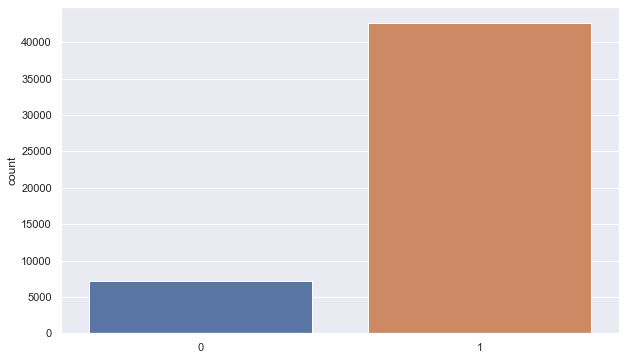

In [19]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x=pred_y, ax=ax)

## 4. Construcción variable de particionamiento

In [20]:
X['Y'] = pred_y

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49942 entries, 0 to 49941
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           49942 non-null  int64  
 1   saldo_actual                       49942 non-null  float64
 2   Promedio de limite_credito         49942 non-null  float64
 3   Promedio de credito_maximo         49942 non-null  float64
 4   Promedio de cantidad_cuotas        49942 non-null  float64
 5   Promedio de valor_cuota            49942 non-null  float64
 6   coaching_impacto                   49942 non-null  int64  
 7   Comunicaciones_saldo_actual        49942 non-null  float64
 8   %_comunicaciones                   49942 non-null  float64
 9   Comunicaciones_garantia            49942 non-null  int64  
 10  Consumo_saldo_actual               49942 non-null  float64
 11  %_consumo                          49942 non-null  flo

## 5. Almacenamiento resultados de predicción

In [21]:
X[X.Y == 1].to_csv('data/result.csv', sep=";", encoding="utf-8", index=False)

X[X.Y == 1].shape

(42688, 34)